In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
#filenames_list = ['cbg.us.txt', 'lng.us.txt', 'alny.us.txt', 'ksu.us.txt', 'cbrl.us.txt', 'wea.us.txt', 'umpq.us.txt', 'bmtc.us.txt', 'pni.us.txt', 'itcb.us.txt', 'ibm.us.txt']

In [3]:
# Define the path, so easier to call files 
path_name = '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/'

In [4]:
cbg_df  = pd.read_csv(path_name+'cbg.us.txt').drop(columns=['Date','OpenInt'])
lng_df   = pd.read_csv(path_name+'lng.us.txt').drop(columns=['Date','OpenInt'])
alny_df  = pd.read_csv(path_name+'alny.us.txt').drop(columns=['Date','OpenInt'])
ksu_df  = pd.read_csv(path_name+'ksu.us.txt').drop(columns=['Date','OpenInt'])
cbrl_df = pd.read_csv(path_name+'cbrl.us.txt').drop(columns=['Date','OpenInt'])
wea_df  = pd.read_csv(path_name+'wea.us.txt').drop(columns=['Date','OpenInt'])
umpq_df   = pd.read_csv(path_name+'umpq.us.txt').drop(columns=['Date','OpenInt'])
bmtc_df  = pd.read_csv(path_name+'bmtc.us.txt').drop(columns=['Date','OpenInt'])
pni_df  = pd.read_csv(path_name+'pni.us.txt').drop(columns=['Date','OpenInt'])
itcb_df  = pd.read_csv(path_name+'itcb.us.txt').drop(columns=['Date','OpenInt'])
ibm_df   = pd.read_csv(path_name+'ibm.us.txt').drop(columns=['Date','OpenInt'])

In [5]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=10, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [6]:
lookback = 10
step = 1
delay = 1
bs = 10

# **This is the example for CBG**

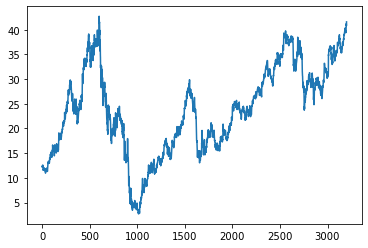

In [7]:
cbg = cbg_df.to_numpy()
cbg_high = cbg[:,1]

plt.plot(range(len(cbg_high)), cbg_high)

In [8]:
cbg_mean = cbg.mean(axis=0)
cbg -= cbg_mean
cbg_std = cbg.std(axis=0)
cbg /= cbg_std

In [9]:
cbg_train_gen = generator(cbg, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
cbg_val_gen = generator(cbg, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
cbg_test_gen = generator(cbg, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

cbg_val_steps = (3000 - 2501) // bs
cbg_test_steps = (len(cbg) - 3001 - lookback) // bs

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(cbg_val_steps):
        samples, targets = next(cbg_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.06073455759122778


In [11]:
cbg_model = Sequential()
cbg_model.add(layers.Flatten(input_shape=(lookback // step, cbg.shape[-1])))
cbg_model.add(layers.Dense(32, activation='relu'))
cbg_model.add(layers.Dense(1))
cbg_model.compile(optimizer=RMSprop(), loss='mae')
cbg_history = cbg_model.fit_generator(cbg_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbg_val_gen, 
                              validation_steps=cbg_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 34ms/step - loss: 0.5011 - val_loss: 0.1619
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2715 - val_loss: 0.1570
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2085 - val_loss: 0.2914
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1871 - val_loss: 0.2060
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2196 - val_loss: 0.1791
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1782 - val_loss: 0.1963
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1742 - val_loss: 0.2478
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1759 - val_loss: 0.1285
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1643 - val_loss: 0.0731
Epoch 10/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1485 - val_loss: 0.0834
Epoch 11/25
10/10 

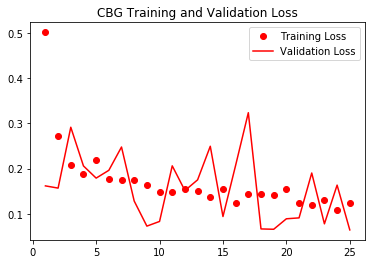

In [12]:
cbg_loss = cbg_history.history['loss']
cbg_val_loss = cbg_history.history['val_loss']
epochs = range(1, len(cbg_loss)+1)

plt.figure()
plt.plot(epochs, cbg_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbg_val_loss, 'r', label='Validation Loss')
plt.title('CBG Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
cbg_model = Sequential()
cbg_model.add(layers.GRU(32, input_shape=(None, cbg.shape[-1])))
cbg_model.add(layers.Dense(1))
cbg_model.compile(optimizer=RMSprop(), loss='mae')
cbg_history = cbg_model.fit_generator(cbg_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbg_val_gen, 
                              validation_steps=cbg_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 69ms/step - loss: 0.5903 - val_loss: 0.3085
Epoch 2/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2053 - val_loss: 0.1005
Epoch 3/25
10/10 [==============================] - 0s 16ms/step - loss: 0.1138 - val_loss: 0.0721
Epoch 4/25
10/10 [==============================] - 0s 17ms/step - loss: 0.1105 - val_loss: 0.0708
Epoch 5/25
10/10 [==============================] - 0s 17ms/step - loss: 0.1030 - val_loss: 0.1118
Epoch 6/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0827 - val_loss: 0.1077
Epoch 7/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0910 - val_loss: 0.0888
Epoch 8/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0821 - val_loss: 0.0440
Epoch 9/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0798 - val_loss: 0.1160
Epoch 10/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0813 - val_loss: 0.0255
Epoch 11/

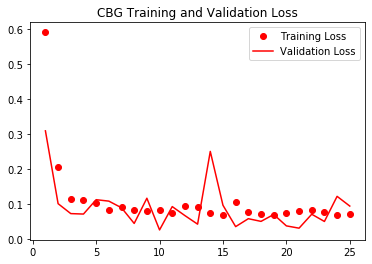

In [14]:
cbg_loss = cbg_history.history['loss']
cbg_val_loss = cbg_history.history['val_loss']
epochs = range(1, len(cbg_loss)+1)

plt.figure()
plt.plot(epochs, cbg_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbg_val_loss, 'r', label='Validation Loss')
plt.title('CBG Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
cbg_model = Sequential()
cbg_model.add(layers.GRU(32, dropout=0.2,
                         recurrent_dropout=0.2,
                         input_shape=(None, cbg.shape[-1])))
cbg_model.add(layers.Dense(1))
cbg_model.compile(optimizer=RMSprop(), loss='mae')
cbg_history = cbg_model.fit_generator(cbg_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbg_val_gen, 
                              validation_steps=cbg_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 77ms/step - loss: 1.5265 - val_loss: 0.5371
Epoch 2/25
10/10 [==============================] - 0s 19ms/step - loss: 0.6784 - val_loss: 0.5669
Epoch 3/25
10/10 [==============================] - 0s 19ms/step - loss: 0.4257 - val_loss: 0.4918
Epoch 4/25
10/10 [==============================] - 0s 18ms/step - loss: 0.3266 - val_loss: 0.3153
Epoch 5/25
10/10 [==============================] - 0s 18ms/step - loss: 0.3063 - val_loss: 0.3581
Epoch 6/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2915 - val_loss: 0.1228
Epoch 7/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2343 - val_loss: 0.1561
Epoch 8/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2839 - val_loss: 0.3497
Epoch 9/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2211 - val_loss: 0.1635
Epoch 10/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2066 - val_loss: 0.1267
Epoch 11/

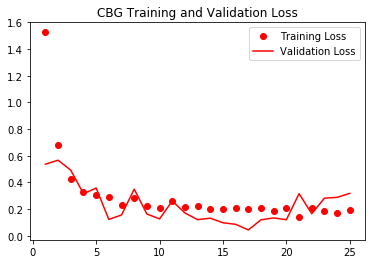

In [16]:
cbg_loss = cbg_history.history['loss']
cbg_val_loss = cbg_history.history['val_loss']
epochs = range(1, len(cbg_loss)+1)

plt.figure()
plt.plot(epochs, cbg_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbg_val_loss, 'r', label='Validation Loss')
plt.title('CBG Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
cbg_model = Sequential()
cbg_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, cbg.shape[-1])))
cbg_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
cbg_model.add(layers.Dense(1))
cbg_model.compile(optimizer=RMSprop(), loss='mae')
cbg_history = cbg_model.fit_generator(cbg_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbg_val_gen, 
                              validation_steps=cbg_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 145ms/step - loss: 1.6812 - val_loss: 0.8272
Epoch 2/25
10/10 [==============================] - 0s 30ms/step - loss: 1.3775 - val_loss: 1.0045
Epoch 3/25
10/10 [==============================] - 0s 30ms/step - loss: 1.1013 - val_loss: 0.8579
Epoch 4/25
10/10 [==============================] - 0s 31ms/step - loss: 1.1845 - val_loss: 1.0219
Epoch 5/25
10/10 [==============================] - 0s 30ms/step - loss: 0.5775 - val_loss: 1.2926
Epoch 6/25
10/10 [==============================] - 0s 29ms/step - loss: 0.5672 - val_loss: 1.1935
Epoch 7/25
10/10 [==============================] - 0s 30ms/step - loss: 0.7342 - val_loss: 1.3243
Epoch 8/25
10/10 [==============================] - 0s 29ms/step - loss: 0.7053 - val_loss: 1.2233
Epoch 9/25
10/10 [==============================] - 0s 29ms/step - loss: 0.5043 - val_loss: 1.0523
Epoch 10/25
10/10 [==============================] - 0s 29ms/step - loss: 0.4822 - val_loss: 0.6857
Epoch 11

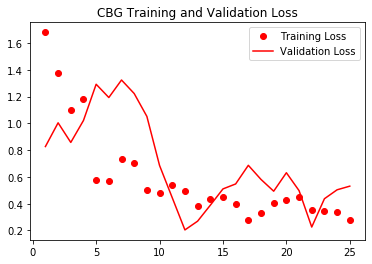

In [18]:
cbg_loss = cbg_history.history['loss']
cbg_val_loss = cbg_history.history['val_loss']
epochs = range(1, len(cbg_loss)+1)

plt.figure()
plt.plot(epochs, cbg_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbg_val_loss, 'r', label='Validation Loss')
plt.title('CBG Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for LNG**

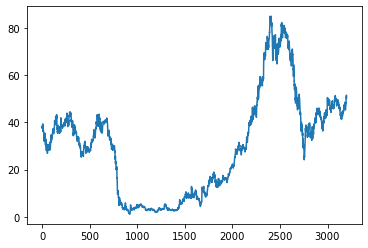

In [19]:
lng = lng_df.to_numpy()
lng_high = lng[:,1]

plt.plot(range(len(lng_high)), lng_high)

In [20]:
lng_mean = lng.mean(axis=0)
lng -= lng_mean
lng_std = lng.std(axis=0)
lng /= lng_std

In [21]:
lng_current = np.array([[41.86,42.40,39.98,40.76,1620000],
               [42.28,42.28,40.70,41.20,1720000],
               [40.95,42.01,40.45,41.87,2910000],
               [41.50,43.16,40.68,42.80,3430000],
               [43.80,44.31,42.50,43.08,3370000],
               [44.36,45.94,43.66,45.69,3670000],
               [46.62,48.67,45.47,46.69,4730000],
               [44.94,45.79,43.16,43.25,3480000],
               [42.63,44.23,42.11,43.28,4030000],
               [44.57,44.81,41.85,42.13,2210000]])
lng_current = np.reshape(lng_current, (1,10,5))

In [22]:
lng_train_gen = generator(lng, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
lng_val_gen = generator(lng, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
lng_test_gen = generator(lng, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

lng_val_steps = (3000 - 2501) // bs
lng_test_steps = (len(lng) - 3001 - lookback) // bs

In [23]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(lng_val_steps):
        samples, targets = next(lng_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.06126865987390975


In [24]:
lng_model = Sequential()
lng_model.add(layers.Flatten(input_shape=(lookback // step, lng.shape[-1])))
lng_model.add(layers.Dense(32, activation='relu'))
lng_model.add(layers.Dense(1))
lng_model.compile(optimizer=RMSprop(), loss='mae')
lng_history = lng_model.fit_generator(lng_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=lng_val_gen, 
                              validation_steps=lng_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 18ms/step - loss: 1.1441 - val_loss: 0.8278
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2559 - val_loss: 0.1216
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2231 - val_loss: 0.6239
Epoch 4/25
10/10 [==============================] - 0s 12ms/step - loss: 0.2215 - val_loss: 0.1089
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2144 - val_loss: 0.1762
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2000 - val_loss: 0.7275
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2364 - val_loss: 0.4962
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1886 - val_loss: 0.2375
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1851 - val_loss: 0.4560
Epoch 10/25
10/10 [==============================] - 0s 10ms/step - loss: 0.2179 - val_loss: 0.1401
Epoch 11/25
10/1

In [25]:
#the high the next day was 42.78

x = lng_model.predict(lng_current)
y = (x*lng_std[1])+lng_mean[1]
print(y)

[[-351252.94]]


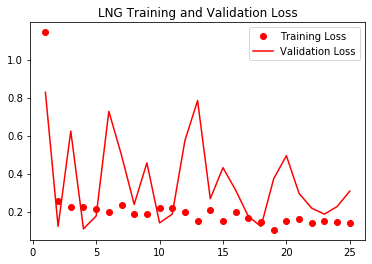

In [26]:
lng_loss = lng_history.history['loss']
lng_val_loss = lng_history.history['val_loss']
epochs = range(1, len(lng_loss)+1)

plt.figure()
plt.plot(epochs, lng_loss, 'ro', label='Training Loss')
plt.plot(epochs, lng_val_loss, 'r', label='Validation Loss')
plt.title('LNG Training and Validation Loss')
plt.legend()
plt.show()

In [27]:
lng_model = Sequential()
lng_model.add(layers.GRU(32, input_shape=(None, lng.shape[-1])))
lng_model.add(layers.Dense(1))
lng_model.compile(optimizer=RMSprop(), loss='mae')
lng_history = lng_model.fit_generator(lng_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=lng_val_gen, 
                              validation_steps=lng_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 64ms/step - loss: 0.3756 - val_loss: 0.1048
Epoch 2/25
10/10 [==============================] - 0s 17ms/step - loss: 0.1111 - val_loss: 0.0480
Epoch 3/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0761 - val_loss: 0.1203
Epoch 4/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0627 - val_loss: 0.1117
Epoch 5/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0616 - val_loss: 0.1367
Epoch 6/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0609 - val_loss: 0.0980
Epoch 7/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0616 - val_loss: 0.0800
Epoch 8/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0513 - val_loss: 0.0374
Epoch 9/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0582 - val_loss: 0.0240
Epoch 10/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0523 - val_loss: 0.1026
Epoch 11/

In [28]:
#the high the next day was 42.78

x = lng_model.predict(lng_current)
y = (x*lng_std[1])+lng_mean[1]
print(y)

[[17.81889]]


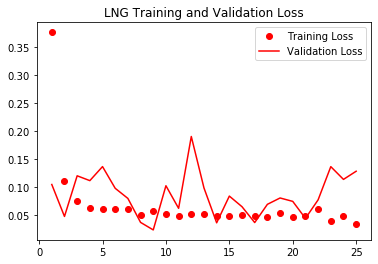

In [29]:
lng_loss = lng_history.history['loss']
lng_val_loss = lng_history.history['val_loss']
epochs = range(1, len(lng_loss)+1)

plt.figure()
plt.plot(epochs, lng_loss, 'ro', label='Training Loss')
plt.plot(epochs, lng_val_loss, 'r', label='Validation Loss')
plt.title('LNG Training and Validation Loss')
plt.legend()
plt.show()

In [30]:
lng_model = Sequential()
lng_model.add(layers.GRU(32, dropout=0.2,
                         recurrent_dropout=0.2,
                         input_shape=(None, lng.shape[-1])))
lng_model.add(layers.Dense(1))
lng_model.compile(optimizer=RMSprop(), loss='mae')
lng_history = lng_model.fit_generator(lng_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=lng_val_gen, 
                              validation_steps=lng_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 76ms/step - loss: 0.4176 - val_loss: 0.2642
Epoch 2/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2959 - val_loss: 0.1727
Epoch 3/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2964 - val_loss: 0.0545
Epoch 4/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2192 - val_loss: 0.1415
Epoch 5/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2341 - val_loss: 0.1331
Epoch 6/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2504 - val_loss: 0.0679
Epoch 7/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2146 - val_loss: 0.0490
Epoch 8/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2105 - val_loss: 0.0989
Epoch 9/25
10/10 [==============================] - 0s 22ms/step - loss: 0.1956 - val_loss: 0.0971
Epoch 10/25
10/10 [==============================] - 0s 18ms/step - loss: 0.1998 - val_loss: 0.0864
Epoch 11/

In [31]:
#the high the next day was 42.78

x = lng_model.predict(lng_current)
y = (x*lng_std[1])+lng_mean[1]
print(y)

[[18.106691]]


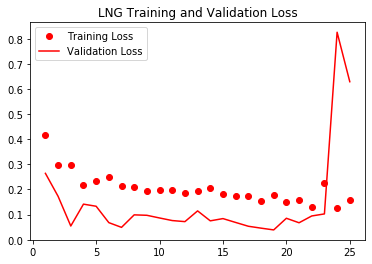

In [32]:
lng_loss = lng_history.history['loss']
lng_val_loss = lng_history.history['val_loss']
epochs = range(1, len(lng_loss)+1)

plt.figure()
plt.plot(epochs, lng_loss, 'ro', label='Training Loss')
plt.plot(epochs, lng_val_loss, 'r', label='Validation Loss')
plt.title('LNG Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
lng_model = Sequential()
lng_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, lng.shape[-1])))
lng_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
lng_model.add(layers.Dense(1))
lng_model.compile(optimizer=RMSprop(), loss='mae')
lng_history = lng_model.fit_generator(lng_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=lng_val_gen, 
                              validation_steps=lng_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 143ms/step - loss: 1.3865 - val_loss: 1.4375
Epoch 2/25
10/10 [==============================] - 0s 29ms/step - loss: 1.2744 - val_loss: 1.0014
Epoch 3/25
10/10 [==============================] - 0s 29ms/step - loss: 1.2563 - val_loss: 0.8744
Epoch 4/25
10/10 [==============================] - 0s 29ms/step - loss: 1.0729 - val_loss: 0.8962
Epoch 5/25
10/10 [==============================] - 0s 29ms/step - loss: 1.4290 - val_loss: 0.7708
Epoch 6/25
10/10 [==============================] - 0s 28ms/step - loss: 0.7504 - val_loss: 0.7495
Epoch 7/25
10/10 [==============================] - 0s 29ms/step - loss: 1.0139 - val_loss: 0.8162
Epoch 8/25
10/10 [==============================] - 0s 29ms/step - loss: 0.9028 - val_loss: 0.4880
Epoch 9/25
10/10 [==============================] - 0s 28ms/step - loss: 0.8070 - val_loss: 0.3300
Epoch 10/25
10/10 [==============================] - 0s 37ms/step - loss: 0.6917 - val_loss: 0.2140
Epoch 11

In [34]:
#the high the next day was 42.78

x = lng_model.predict(lng_current)
y = (x*lng_std[1])+lng_mean[1]
print(y)

[[25.789062]]


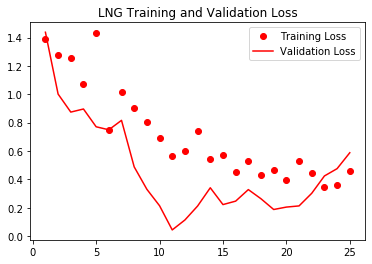

In [35]:
lng_loss = lng_history.history['loss']
lng_val_loss = lng_history.history['val_loss']
epochs = range(1, len(lng_loss)+1)

plt.figure()
plt.plot(epochs, lng_loss, 'ro', label='Training Loss')
plt.plot(epochs, lng_val_loss, 'r', label='Validation Loss')
plt.title('LNG Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for KSU**

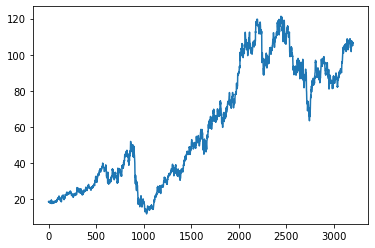

In [36]:
ksu = ksu_df.to_numpy()
ksu_high = ksu[:,1]

plt.plot(range(len(ksu_high)), ksu_high)

In [37]:
ksu_mean = ksu.mean(axis=0)
ksu -= ksu_mean
ksu_std = ksu.std(axis=0)
ksu /= ksu_std

In [38]:
ksu_current = np.array([[125.65,127.00,125.49,126.82,79080],
               [126.94,126.94,126.25,126.81,25940],
               [126.79,127.16,126.24,127.07,44660],
               [127.08,127.44,126.32,127.30,145372],
               [126.69,132.04,128.80,131.86,110463],
               [131.82,132.60,131.41,132.27,63137],
               [132.35,133.55,133.22,133.31,55021],
               [133.33,133.45,132.28,132.34,69418],
               [132.35,132.43,131.41,131.60,26567],
               [131.61,132.09,131.40,131.71,35085]])


ksu_current = np.reshape(ksu_current, (1,10,5))

In [39]:
ksu_train_gen = generator(ksu, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
ksu_val_gen = generator(ksu, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
ksu_test_gen = generator(ksu, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

ksu_val_steps = (3000 - 2501) // bs
ksu_test_steps = (len(ksu) - 3001 - lookback) // bs

In [40]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(ksu_val_steps):
        samples, targets = next(ksu_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.04900299272763669


In [41]:
ksu_model = Sequential()
ksu_model.add(layers.Flatten(input_shape=(lookback // step, ksu.shape[-1])))
ksu_model.add(layers.Dense(32, activation='relu'))
ksu_model.add(layers.Dense(1))
ksu_model.compile(optimizer=RMSprop(), loss='mae')
ksu_history = ksu_model.fit_generator(ksu_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ksu_val_gen, 
                              validation_steps=ksu_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 18ms/step - loss: 0.5168 - val_loss: 0.1006
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2772 - val_loss: 0.4119
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2005 - val_loss: 0.2992
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1884 - val_loss: 0.2035
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1467 - val_loss: 0.2471
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1359 - val_loss: 0.5662
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1610 - val_loss: 0.2898
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1404 - val_loss: 0.1836
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1490 - val_loss: 0.1872
Epoch 10/25
10/10 [==============================] - 0s 8ms/step - loss: 0.1608 - val_loss: 0.2209
Epoch 11/25
10/10 

In [42]:
#the high the day after this is 131.86

x = ksu_model.predict(ksu_current)
y = (x*ksu_std[1])+ksu_mean[1]
print(y)

[[-119431.836]]


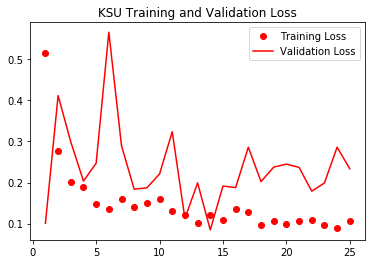

In [43]:
ksu_loss = ksu_history.history['loss']
ksu_val_loss = ksu_history.history['val_loss']
epochs = range(1, len(ksu_loss)+1)

plt.figure()
plt.plot(epochs, ksu_loss, 'ro', label='Training Loss')
plt.plot(epochs, ksu_val_loss, 'r', label='Validation Loss')
plt.title('KSU Training and Validation Loss')
plt.legend()
plt.show()

In [44]:
ksu_model = Sequential()
ksu_model.add(layers.GRU(32, input_shape=(None, ksu.shape[-1])))
ksu_model.add(layers.Dense(1))
ksu_model.compile(optimizer=RMSprop(), loss='mae')
ksu_history = ksu_model.fit_generator(ksu_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ksu_val_gen, 
                              validation_steps=ksu_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 66ms/step - loss: 0.4729 - val_loss: 0.2010
Epoch 2/25
10/10 [==============================] - 0s 17ms/step - loss: 0.1000 - val_loss: 0.0956
Epoch 3/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0749 - val_loss: 0.2560
Epoch 4/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0801 - val_loss: 0.0454
Epoch 5/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0625 - val_loss: 0.1220
Epoch 6/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0680 - val_loss: 0.1820
Epoch 7/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0611 - val_loss: 0.1118
Epoch 8/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0692 - val_loss: 0.0706
Epoch 9/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0651 - val_loss: 0.0988
Epoch 10/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0680 - val_loss: 0.0376
Epoch 11/

In [45]:
#the high the day after this is 131.86

x = ksu_model.predict(ksu_current)
y = (x*ksu_std[1])+ksu_mean[1]
print(y)

[[68.69141]]


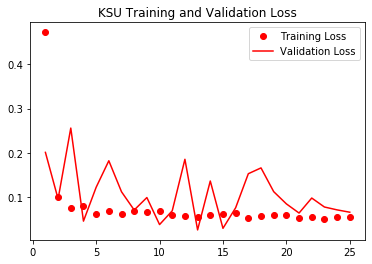

In [46]:
ksu_loss = ksu_history.history['loss']
ksu_val_loss = ksu_history.history['val_loss']
epochs = range(1, len(ksu_loss)+1)

plt.figure()
plt.plot(epochs, ksu_loss, 'ro', label='Training Loss')
plt.plot(epochs, ksu_val_loss, 'r', label='Validation Loss')
plt.title('KSU Training and Validation Loss')
plt.legend()
plt.show()

In [47]:
ksu_model = Sequential()
ksu_model.add(layers.GRU(32, dropout=0.2,
                         recurrent_dropout=0.2,
                         input_shape=(None, ksu.shape[-1])))
ksu_model.add(layers.Dense(1))
ksu_model.compile(optimizer=RMSprop(), loss='mae')
ksu_history = ksu_model.fit_generator(ksu_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ksu_val_gen, 
                              validation_steps=ksu_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 76ms/step - loss: 0.4115 - val_loss: 0.1498
Epoch 2/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2514 - val_loss: 0.1312
Epoch 3/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2393 - val_loss: 0.0998
Epoch 4/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2044 - val_loss: 0.1446
Epoch 5/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2059 - val_loss: 0.2367
Epoch 6/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2745 - val_loss: 0.0942
Epoch 7/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2041 - val_loss: 0.1385
Epoch 8/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1865 - val_loss: 0.1099
Epoch 9/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1957 - val_loss: 0.1805
Epoch 10/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1819 - val_loss: 0.1323
Epoch 11/

In [48]:
#the high the day after this is 131.86

x = ksu_model.predict(ksu_current)
y = (x*ksu_std[1])+ksu_mean[1]
print(y)

[[60.13223]]


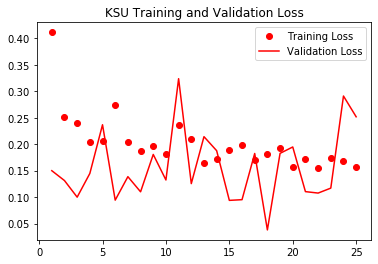

In [49]:
ksu_loss = ksu_history.history['loss']
ksu_val_loss = ksu_history.history['val_loss']
epochs = range(1, len(ksu_loss)+1)

plt.figure()
plt.plot(epochs, ksu_loss, 'ro', label='Training Loss')
plt.plot(epochs, ksu_val_loss, 'r', label='Validation Loss')
plt.title('KSU Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
ksu_model = Sequential()
ksu_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, ksu.shape[-1])))
ksu_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
ksu_model.add(layers.Dense(1))
ksu_model.compile(optimizer=RMSprop(), loss='mae')
ksu_history = ksu_model.fit_generator(ksu_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ksu_val_gen, 
                              validation_steps=ksu_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 148ms/step - loss: 2.7218 - val_loss: 0.7454
Epoch 2/25
10/10 [==============================] - 0s 28ms/step - loss: 2.4974 - val_loss: 0.9253
Epoch 3/25
10/10 [==============================] - 0s 30ms/step - loss: 1.7071 - val_loss: 0.8586
Epoch 4/25
10/10 [==============================] - 0s 30ms/step - loss: 1.6082 - val_loss: 0.8787
Epoch 5/25
10/10 [==============================] - 0s 30ms/step - loss: 1.5117 - val_loss: 0.6295
Epoch 6/25
10/10 [==============================] - 0s 29ms/step - loss: 1.0885 - val_loss: 0.7218
Epoch 7/25
10/10 [==============================] - 0s 29ms/step - loss: 0.9248 - val_loss: 0.8144
Epoch 8/25
10/10 [==============================] - 0s 29ms/step - loss: 0.8724 - val_loss: 0.3725
Epoch 9/25
10/10 [==============================] - 0s 30ms/step - loss: 0.9464 - val_loss: 0.2736
Epoch 10/25
10/10 [==============================] - 0s 30ms/step - loss: 0.6581 - val_loss: 0.2591
Epoch 11

In [51]:
#the high the day after this is 131.86

x = ksu_model.predict(ksu_current)
y = (x*ksu_std[1])+ksu_mean[1]
print(y)

[[61.474426]]


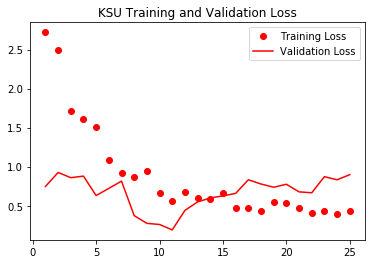

In [52]:
ksu_loss = ksu_history.history['loss']
ksu_val_loss = ksu_history.history['val_loss']
epochs = range(1, len(ksu_loss)+1)

plt.figure()
plt.plot(epochs, ksu_loss, 'ro', label='Training Loss')
plt.plot(epochs, ksu_val_loss, 'r', label='Validation Loss')
plt.title('KSU Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for ALNY**

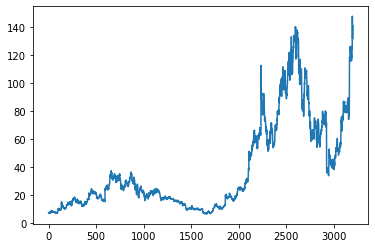

In [53]:
alny = alny_df.to_numpy()
alny_high = alny[:,1]

plt.plot(range(len(alny_high)), alny_high)

In [54]:
alny_mean = alny.mean(axis=0)
alny -= alny_mean
alny_std = alny.std(axis=0)
alny /= alny_std

In [55]:
alny_current = np.array([[140.00,141.74,137.72,140.11,383334],
               [139.82,144.41,139.82,141.64,1090000],
               [143.75,147.00,141.80,145.63,696386],
               [147.28,147.41,142.27,142.70,487329],
               [142.43,142.89,136.64,137.50,626613],
               [140.01,141.76,132.91,135.81,651230],
               [136.27,138.33,131.57,131.70,679350],
               [130.45,131.37,124.95,128.97,525665],
               [130.54,136.77,129.02,136.63,923186],
               [137.53,143.18,137.05,141.23,735555]])


alny_current = np.reshape(alny_current, (1,10,5))

In [56]:
alny_train_gen = generator(alny, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
alny_val_gen = generator(alny, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
alny_test_gen = generator(alny, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

alny_val_steps = (3000 - 2501) // bs
alny_test_steps = (len(alny) - 3001 - lookback) // bs

In [57]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(alny_val_steps):
        samples, targets = next(alny_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.09822155096211994


In [58]:
alny_model = Sequential()
alny_model.add(layers.Flatten(input_shape=(lookback // step, alny.shape[-1])))
alny_model.add(layers.Dense(32, activation='relu'))
alny_model.add(layers.Dense(1))
alny_model.compile(optimizer=RMSprop(), loss='mae')
alny_history = alny_model.fit_generator(alny_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=lng_val_gen, 
                              validation_steps=lng_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2345 - val_loss: 0.3554
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1656 - val_loss: 0.7188
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.0968 - val_loss: 0.1764
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1127 - val_loss: 0.6365
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1250 - val_loss: 0.2950
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1131 - val_loss: 0.3670
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1118 - val_loss: 0.4571
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.0938 - val_loss: 0.3938
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1002 - val_loss: 0.4009
Epoch 10/25
10/10 [==============================] - 0s 9ms/step - loss: 0.0935 - val_loss: 0.1544
Epoch 11/25
10/10 

In [59]:
#the high on the day after this was 151.84
x = alny_model.predict(alny_current)
y = (x*alny_std[1])+alny_mean[1]
print(y)

[[4269046.]]


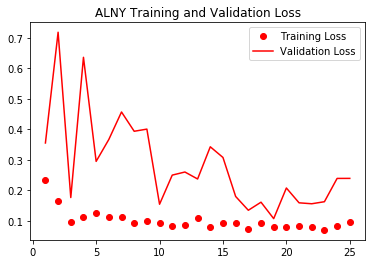

In [60]:
alny_loss = alny_history.history['loss']
alny_val_loss = alny_history.history['val_loss']
epochs = range(1, len(alny_loss)+1)

plt.figure()
plt.plot(epochs, alny_loss, 'ro', label='Training Loss')
plt.plot(epochs, alny_val_loss, 'r', label='Validation Loss')
plt.title('ALNY Training and Validation Loss')
plt.legend()
plt.show()

In [61]:
alny_model = Sequential()
alny_model.add(layers.GRU(32, input_shape=(None, alny.shape[-1])))
alny_model.add(layers.Dense(1))
alny_model.compile(optimizer=RMSprop(), loss='mae')
alny_history = alny_model.fit_generator(alny_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=alny_val_gen, 
                              validation_steps=alny_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 63ms/step - loss: 0.3253 - val_loss: 1.2664
Epoch 2/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0816 - val_loss: 0.9618
Epoch 3/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0818 - val_loss: 0.7809
Epoch 4/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0531 - val_loss: 0.7923
Epoch 5/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0610 - val_loss: 0.6437
Epoch 6/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0582 - val_loss: 0.7289
Epoch 7/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0498 - val_loss: 0.7732
Epoch 8/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.8249
Epoch 9/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0579 - val_loss: 0.5004
Epoch 10/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0524 - val_loss: 0.8884
Epoch 11/

In [62]:
#the high on the day after this was 151.84
x = alny_model.predict(alny_current)
y = (x*alny_std[1])+alny_mean[1]
print(y)

[[72.532455]]


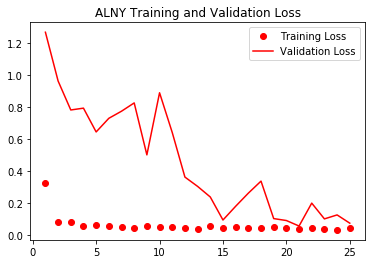

In [63]:
alny_loss = alny_history.history['loss']
alny_val_loss = alny_history.history['val_loss']
epochs = range(1, len(alny_loss)+1)

plt.figure()
plt.plot(epochs, alny_loss, 'ro', label='Training Loss')
plt.plot(epochs, alny_val_loss, 'r', label='Validation Loss')
plt.title('ALNY Training and Validation Loss')
plt.legend()
plt.show()

In [64]:
alny_model = Sequential()
alny_model.add(layers.GRU(32, dropout=0.2,
                          recurrent_dropout=0.2,
                          input_shape=(None, alny.shape[-1])))
alny_model.add(layers.Dense(1))
alny_model.compile(optimizer=RMSprop(), loss='mae')
alny_history = alny_model.fit_generator(alny_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=alny_val_gen, 
                              validation_steps=alny_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 74ms/step - loss: 0.1785 - val_loss: 0.3954
Epoch 2/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1665 - val_loss: 0.2792
Epoch 3/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1369 - val_loss: 0.3871
Epoch 4/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1689 - val_loss: 0.2662
Epoch 5/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1472 - val_loss: 0.4484
Epoch 6/25
10/10 [==============================] - 0s 18ms/step - loss: 0.1324 - val_loss: 0.0339
Epoch 7/25
10/10 [==============================] - 0s 18ms/step - loss: 0.1370 - val_loss: 0.1649
Epoch 8/25
10/10 [==============================] - 0s 18ms/step - loss: 0.1371 - val_loss: 0.0577
Epoch 9/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1453 - val_loss: 0.1346
Epoch 10/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1569 - val_loss: 0.0419
Epoch 11/

In [65]:
#the high on the day after this was 151.84
x = alny_model.predict(alny_current)
y = (x*alny_std[1])+alny_mean[1]
print(y)

[[39.87685]]


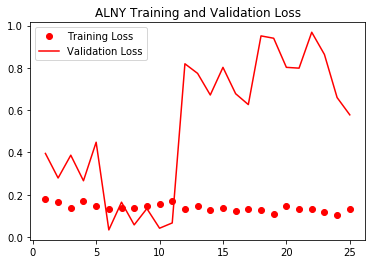

In [66]:
alny_loss = alny_history.history['loss']
alny_val_loss = alny_history.history['val_loss']
epochs = range(1, len(alny_loss)+1)

plt.figure()
plt.plot(epochs, alny_loss, 'ro', label='Training Loss')
plt.plot(epochs, alny_val_loss, 'r', label='Validation Loss')
plt.title('ALNY Training and Validation Loss')
plt.legend()
plt.show()

In [67]:
alny_model = Sequential()
alny_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, alny.shape[-1])))
alny_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
alny_model.add(layers.Dense(1))
alny_model.compile(optimizer=RMSprop(), loss='mae')
alny_history = alny_model.fit_generator(alny_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=alny_val_gen, 
                              validation_steps=alny_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 146ms/step - loss: 0.9172 - val_loss: 0.6820
Epoch 2/25
10/10 [==============================] - 0s 30ms/step - loss: 0.7940 - val_loss: 0.7094
Epoch 3/25
10/10 [==============================] - 0s 30ms/step - loss: 0.6720 - val_loss: 0.6550
Epoch 4/25
10/10 [==============================] - 0s 30ms/step - loss: 0.5260 - val_loss: 0.9295
Epoch 5/25
10/10 [==============================] - 0s 29ms/step - loss: 0.3550 - val_loss: 0.9676
Epoch 6/25
10/10 [==============================] - 0s 29ms/step - loss: 0.4331 - val_loss: 0.6474
Epoch 7/25
10/10 [==============================] - 0s 29ms/step - loss: 0.3229 - val_loss: 0.6157
Epoch 8/25
10/10 [==============================] - 0s 29ms/step - loss: 0.4127 - val_loss: 1.0153
Epoch 9/25
10/10 [==============================] - 0s 29ms/step - loss: 0.4330 - val_loss: 0.6328
Epoch 10/25
10/10 [==============================] - 0s 29ms/step - loss: 0.4073 - val_loss: 0.6601
Epoch 11

In [68]:
#the high on the day after this was 151.84
x = alny_model.predict(alny_current)
y = (x*alny_std[1])+alny_mean[1]
print(y)

[[34.98025]]


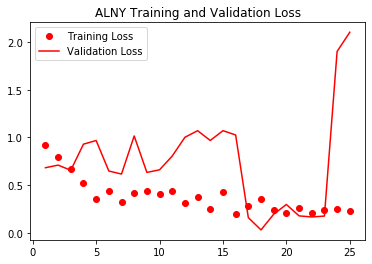

In [69]:
alny_loss = alny_history.history['loss']
alny_val_loss = alny_history.history['val_loss']
epochs = range(1, len(alny_loss)+1)

plt.figure()
plt.plot(epochs, alny_loss, 'ro', label='Training Loss')
plt.plot(epochs, alny_val_loss, 'r', label='Validation Loss')
plt.title('ALNY Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for CBRL**

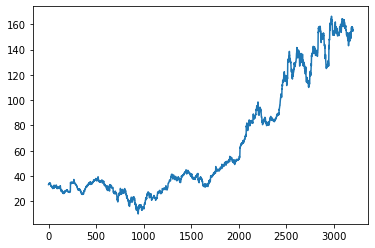

In [70]:
cbrl = cbrl_df.to_numpy()
cbrl_high = cbrl[:,1]

plt.plot(range(len(cbrl_high)), cbrl_high)

In [71]:
cbrl_mean = cbrl.mean(axis=0)
cbrl -= cbrl_mean
cbrl_std = cbrl.std(axis=0)
cbrl /= cbrl_std

In [74]:
cbrl_current = np.array([[84.46,91.50,84.04,1430000],
               [93.29,93.54,85.51,88.36,721855],
               [88.57,89.98,86.96,88.59,570862],
               [90.13,96.26,89.51,94.62,688400],
               [99.39,102.08,94.93,97.13,905883],
               [101.99,105.42,99.82,101.87,1180000],
               [100.05,100.85,96.59,97.40,1300000],
               [93.82,95.60,91.27,93.73,509156],
               [90.77,92.50,87.83,91.10,582985],
               [93.00,94.13,86.71,86.89,745933]])


cbrl_current = np.reshape(cbrl_current, (1,10,5))

ValueError: cannot reshape array of size 10 into shape (1,10,5)

In [ ]:
cbrl_train_gen = generator(cbrl, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
cbrl_val_gen = generator(cbrl, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
cbrl_test_gen = generator(cbrl, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

cbrl_val_steps = (3000 - 2501) // bs
cbrl_test_steps = (len(cbrl) - 3001 - lookback) // bs

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(cbrl_val_steps):
        samples, targets = next(cbrl_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

In [ ]:
cbrl_model = Sequential()
cbrl_model.add(layers.Flatten(input_shape=(lookback // step, cbrl.shape[-1])))
cbrl_model.add(layers.Dense(32, activation='relu'))
cbrl_model.add(layers.Dense(1))
cbrl_model.compile(optimizer=RMSprop(), loss='mae')
cbrl_history = cbrl_model.fit_generator(cbrl_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbrl_val_gen, 
                              validation_steps=cbrl_val_steps)

In [ ]:
#the high on the day after this was 89.06
x = cbrl_model.predict(cbrl_current)
y = (x*cbrl_std[1])+cbrl_mean[1]
print(y)

In [ ]:
cbrl_loss = cbrl_history.history['loss']
cbrl_val_loss = cbrl_history.history['val_loss']
epochs = range(1, len(cbrl_loss)+1)

plt.figure()
plt.plot(epochs, cbrl_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbrl_val_loss, 'r', label='Validation Loss')
plt.title('CBRL Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
cbrl_model = Sequential()
cbrl_model.add(layers.GRU(32, input_shape=(None, cbrl.shape[-1])))
cbrl_model.add(layers.Dense(1))
cbrl_model.compile(optimizer=RMSprop(), loss='mae')
cbrl_history = cbrl_model.fit_generator(cbrl_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbrl_val_gen, 
                              validation_steps=cbrl_val_steps)

In [ ]:
#the high on the day after this was 89.06
x = cbrl_model.predict(cbrl_current)
y = (x*cbrl_std[1])+cbrl_mean[1]
print(y)

In [ ]:
cbrl_loss = cbrl_history.history['loss']
cbrl_val_loss = cbrl_history.history['val_loss']
epochs = range(1, len(cbrl_loss)+1)

plt.figure()
plt.plot(epochs, cbrl_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbrl_val_loss, 'r', label='Validation Loss')
plt.title('CBRL Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
cbrl_model = Sequential()
cbrl_model.add(layers.GRU(32, dropout=0.2,
                          recurrent_dropout=0.2,
                          input_shape=(None, cbrl.shape[-1])))
cbrl_model.add(layers.Dense(1))
cbrl_model.compile(optimizer=RMSprop(), loss='mae')
cbrl_history = cbrl_model.fit_generator(cbrl_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbrl_val_gen, 
                              validation_steps=cbrl_val_steps)

In [ ]:
#the high on the day after this was 89.06
x = cbrl_model.predict(cbrl_current)
y = (x*cbrl_std[1])+cbrl_mean[1]
print(y)

In [ ]:
cbrl_loss = cbrl_history.history['loss']
cbrl_val_loss = cbrl_history.history['val_loss']
epochs = range(1, len(cbrl_loss)+1)

plt.figure()
plt.plot(epochs, cbrl_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbrl_val_loss, 'r', label='Validation Loss')
plt.title('CBRL Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
cbrl_model = Sequential()
cbrl_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, cbrl.shape[-1])))
cbrl_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
cbrl_model.add(layers.Dense(1))
cbrl_model.compile(optimizer=RMSprop(), loss='mae')
cbrl_history = cbrl_model.fit_generator(cbrl_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=cbrl_val_gen, 
                              validation_steps=cbrl_val_steps)

In [ ]:
#the high on the day after this was 89.06
x = cbrl_model.predict(cbrl_current)
y = (x*cbrl_std[1])+cbrl_mean[1]
print(y)

In [ ]:
cbrl_loss = cbrl_history.history['loss']
cbrl_val_loss = cbrl_history.history['val_loss']
epochs = range(1, len(cbrl_loss)+1)

plt.figure()
plt.plot(epochs, cbrl_loss, 'ro', label='Training Loss')
plt.plot(epochs, cbrl_val_loss, 'r', label='Validation Loss')
plt.title('CBRL Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for WEA**

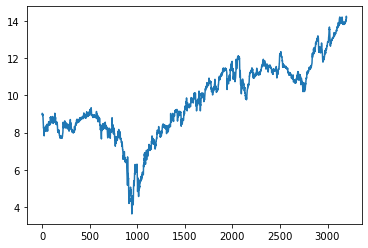

In [75]:
wea = wea_df.to_numpy()
wea_high = wea[:,1]

plt.plot(range(len(wea_high)), wea_high)

In [76]:
wea_mean = wea.mean(axis=0)
wea -= wea_mean
wea_std = wea.std(axis=0)
wea /= wea_std

In [77]:
wea_current = np.array([[12.18,12.18,12.04,12.14,7031],
               [12.16,12.16,12.00,12.04,30861],
               [12.12,12.12,11.87,11.88,26844],
               [11.98,12.01,11.89,12.01,40112],
               [11.99,11.99,11.82,11.96,27653],
               [11.97,12.15,11.94,12.12,25288],
               [12.23,12.28,12.15,12.28,25256],
               [12.39,12.47,12.21,12.31,41192],
               [12.40,12.44,12.26,12.44,22114],
               [12.37,12.48,12.37,12.43,10214]])


wea_current = np.reshape(wea_current, (1,10,5))

In [78]:
wea_train_gen = generator(wea, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
wea_val_gen = generator(wea, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
wea_test_gen = generator(wea, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

wea_val_steps = (3000 - 2501) // bs
wea_test_steps = (len(wea) - 3001 - lookback) // bs

In [79]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(wea_val_steps):
        samples, targets = next(wea_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.035203437957204424


In [80]:
wea_model = Sequential()
wea_model.add(layers.Flatten(input_shape=(lookback // step, wea.shape[-1])))
wea_model.add(layers.Dense(32, activation='relu'))
wea_model.add(layers.Dense(1))
wea_model.compile(optimizer=RMSprop(), loss='mae')
wea_history = wea_model.fit_generator(wea_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=wea_val_gen, 
                              validation_steps=wea_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 18ms/step - loss: 0.3360 - val_loss: 0.1511
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2917 - val_loss: 0.1424
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2225 - val_loss: 0.0971
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2365 - val_loss: 0.2177
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2063 - val_loss: 0.0873
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2022 - val_loss: 0.0954
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1340 - val_loss: 0.0762
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1748 - val_loss: 0.1689
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1959 - val_loss: 0.1503
Epoch 10/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1529 - val_loss: 0.3188
Epoch 11/25
10/10 

In [81]:
#the high on the day after this was 12.54
x = wea_model.predict(wea_current)
y = (x*wea_std[1])+wea_mean[1]
print(y)

[[2830.6042]]


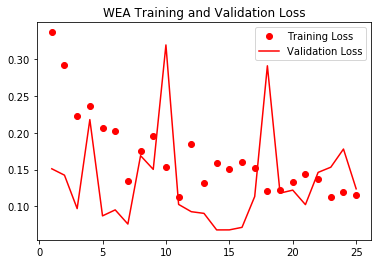

In [82]:
wea_loss = wea_history.history['loss']
wea_val_loss = wea_history.history['val_loss']
epochs = range(1, len(wea_loss)+1)

plt.figure()
plt.plot(epochs, wea_loss, 'ro', label='Training Loss')
plt.plot(epochs, wea_val_loss, 'r', label='Validation Loss')
plt.title('WEA Training and Validation Loss')
plt.legend()
plt.show()

In [83]:
wea_model = Sequential()
wea_model.add(layers.GRU(32, input_shape=(None, wea.shape[-1])))
wea_model.add(layers.Dense(1))
wea_model.compile(optimizer=RMSprop(), loss='mae')
wea_history = wea_model.fit_generator(wea_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=wea_val_gen, 
                              validation_steps=wea_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 67ms/step - loss: 0.3842 - val_loss: 0.4384
Epoch 2/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0797 - val_loss: 0.3353
Epoch 3/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0844 - val_loss: 0.1795
Epoch 4/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0755 - val_loss: 0.2320
Epoch 5/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0805 - val_loss: 0.0214
Epoch 6/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0689 - val_loss: 0.2953
Epoch 7/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0529 - val_loss: 0.0653
Epoch 8/25
10/10 [==============================] - 0s 19ms/step - loss: 0.0801 - val_loss: 0.0621
Epoch 9/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0569 - val_loss: 0.0988
Epoch 10/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0755 - val_loss: 0.1325
Epoch 11/

In [84]:
#the high on the day after this was 12.54
x = wea_model.predict(wea_current)
y = (x*wea_std[1])+wea_mean[1]
print(y)

[[8.358489]]


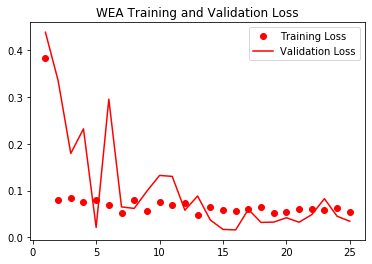

In [85]:
wea_loss = wea_history.history['loss']
wea_val_loss = wea_history.history['val_loss']
epochs = range(1, len(wea_loss)+1)

plt.figure()
plt.plot(epochs, wea_loss, 'ro', label='Training Loss')
plt.plot(epochs, wea_val_loss, 'r', label='Validation Loss')
plt.title('WEA Training and Validation Loss')
plt.legend()
plt.show()

In [86]:
wea_model = Sequential()
wea_model.add(layers.GRU(32, dropout=0.2,
                         recurrent_dropout=0.2,
                         input_shape=(None, wea.shape[-1])))
wea_model.add(layers.Dense(1))
wea_model.compile(optimizer=RMSprop(), loss='mae')
wea_history = wea_model.fit_generator(wea_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=wea_val_gen, 
                              validation_steps=wea_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 76ms/step - loss: 0.4959 - val_loss: 0.2973
Epoch 2/25
10/10 [==============================] - 0s 19ms/step - loss: 0.3076 - val_loss: 0.2052
Epoch 3/25
10/10 [==============================] - 0s 19ms/step - loss: 0.3117 - val_loss: 0.2430
Epoch 4/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2333 - val_loss: 0.1149
Epoch 5/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2231 - val_loss: 0.1319
Epoch 6/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2341 - val_loss: 0.1415
Epoch 7/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1795 - val_loss: 0.2099
Epoch 8/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2207 - val_loss: 0.2218
Epoch 9/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2040 - val_loss: 0.3010
Epoch 10/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1989 - val_loss: 0.3803
Epoch 11/

In [87]:
#the high on the day after this was 12.54
x = wea_model.predict(wea_current)
y = (x*wea_std[1])+wea_mean[1]
print(y)

[[9.284584]]


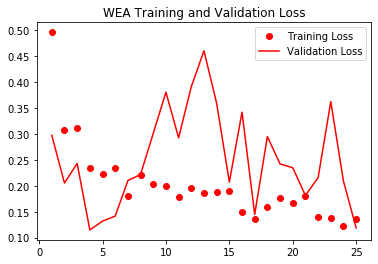

In [88]:
wea_loss = wea_history.history['loss']
wea_val_loss = wea_history.history['val_loss']
epochs = range(1, len(wea_loss)+1)

plt.figure()
plt.plot(epochs, wea_loss, 'ro', label='Training Loss')
plt.plot(epochs, wea_val_loss, 'r', label='Validation Loss')
plt.title('WEA Training and Validation Loss')
plt.legend()
plt.show()

In [89]:
wea_model = Sequential()
wea_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, wea.shape[-1])))
wea_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
wea_model.add(layers.Dense(1))
wea_model.compile(optimizer=RMSprop(), loss='mae')
wea_history = wea_model.fit_generator(wea_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=wea_val_gen, 
                              validation_steps=wea_val_steps)

Epoch 1/25
10/10 [==============================] - 2s 154ms/step - loss: 1.7130 - val_loss: 0.4348
Epoch 2/25
10/10 [==============================] - 0s 31ms/step - loss: 1.0948 - val_loss: 0.4328
Epoch 3/25
10/10 [==============================] - 0s 31ms/step - loss: 0.8575 - val_loss: 0.3880
Epoch 4/25
10/10 [==============================] - 0s 30ms/step - loss: 1.0091 - val_loss: 0.5162
Epoch 5/25
10/10 [==============================] - 0s 32ms/step - loss: 0.7066 - val_loss: 0.6427
Epoch 6/25
10/10 [==============================] - 0s 31ms/step - loss: 0.6224 - val_loss: 0.6141
Epoch 7/25
10/10 [==============================] - 0s 29ms/step - loss: 0.6007 - val_loss: 0.5567
Epoch 8/25
10/10 [==============================] - 0s 29ms/step - loss: 0.6254 - val_loss: 0.4615
Epoch 9/25
10/10 [==============================] - 0s 29ms/step - loss: 0.5760 - val_loss: 0.4486
Epoch 10/25
10/10 [==============================] - 0s 29ms/step - loss: 0.3990 - val_loss: 0.3242
Epoch 11

In [90]:
#the high on the day after this was 12.54
x = wea_model.predict(wea_current)
y = (x*wea_std[1])+wea_mean[1]
print(y)

[[9.469733]]


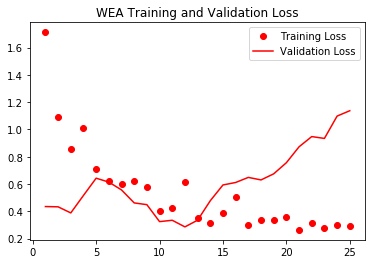

In [91]:
wea_loss = wea_history.history['loss']
wea_val_loss = wea_history.history['val_loss']
epochs = range(1, len(wea_loss)+1)

plt.figure()
plt.plot(epochs, wea_loss, 'ro', label='Training Loss')
plt.plot(epochs, wea_val_loss, 'r', label='Validation Loss')
plt.title('WEA Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for UMPQ**

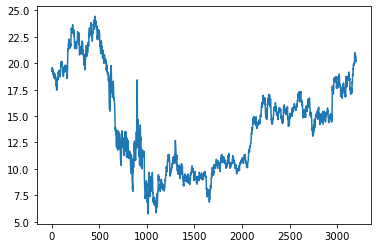

In [92]:
umpq = umpq_df.to_numpy()
umpq_high = umpq[:,1]

plt.plot(range(len(umpq_high)), umpq_high)

In [93]:
umpq_mean = umpq.mean(axis=0)
umpq -= umpq_mean
umpq_std = umpq.std(axis=0)
umpq /= umpq_std

In [94]:
umpq_current = np.array([[10.80,10.93,10.38,10.56,1450000],
               [10.25,10.76,10.06,10.44,2850000],
               [10.50,10.73,10.34,10.68,1320000],
               [10.84,11.46,10.75,11.35,1900000],
               [11.63,12.07,11.51,11.86,1440000],
               [12.34,12.95,12.12,12.86,3530000],
               [12.51,12.88,12.15,12.53,2180000],
               [12.16,12.39,11.59,11.80,1850000],
               [11.61,11.74,11.41,11.67,858204],
               [12.00,12.06,11.30,11.33,1120000]])


umpq_current = np.reshape(umpq_current, (1,10,5))

In [95]:
umpq_train_gen = generator(umpq, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
umpq_val_gen = generator(umpq, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
umpq_test_gen = generator(umpq, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

umpq_val_steps = (3000 - 2501) // bs
umpq_test_steps = (len(umpq) - 3001 - lookback) // bs

In [96]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(umpq_val_steps):
        samples, targets = next(umpq_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.048030553261476226


In [97]:
umpq_model = Sequential()
umpq_model.add(layers.Flatten(input_shape=(lookback // step, umpq.shape[-1])))
umpq_model.add(layers.Dense(32, activation='relu'))
umpq_model.add(layers.Dense(1))
umpq_model.compile(optimizer=RMSprop(), loss='mae')
umpq_history = umpq_model.fit_generator(umpq_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=umpq_val_gen, 
                              validation_steps=umpq_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 18ms/step - loss: 0.6235 - val_loss: 0.1796
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.3325 - val_loss: 0.2493
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2206 - val_loss: 0.1043
Epoch 4/25
10/10 [==============================] - 0s 8ms/step - loss: 0.2150 - val_loss: 0.2344
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1794 - val_loss: 0.1216
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.2044 - val_loss: 0.0770
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1938 - val_loss: 0.0826
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1715 - val_loss: 0.1623
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1506 - val_loss: 0.3271
Epoch 10/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1695 - val_loss: 0.0707
Epoch 11/25
10/10 

In [98]:
#the high on the day after this was 11.56
x = umpq_model.predict(umpq_current)
y = (x*umpq_std[1])+umpq_mean[1]
print(y)

[[-1115122.6]]


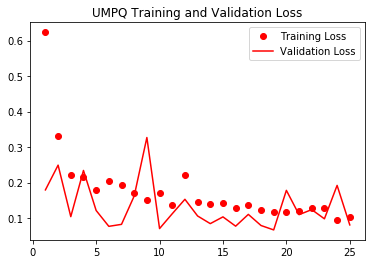

In [99]:
umpq_loss = umpq_history.history['loss']
umpq_val_loss = umpq_history.history['val_loss']
epochs = range(1, len(umpq_loss)+1)

plt.figure()
plt.plot(epochs, umpq_loss, 'ro', label='Training Loss')
plt.plot(epochs, umpq_val_loss, 'r', label='Validation Loss')
plt.title('UMPQ Training and Validation Loss')
plt.legend()
plt.show()

In [100]:
umpq_model = Sequential()
umpq_model.add(layers.GRU(32, input_shape=(None, umpq.shape[-1])))
umpq_model.add(layers.Dense(1))
umpq_model.compile(optimizer=RMSprop(), loss='mae')
umpq_history = umpq_model.fit_generator(umpq_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=umpq_val_gen, 
                              validation_steps=umpq_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 69ms/step - loss: 0.3153 - val_loss: 0.0400
Epoch 2/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0837 - val_loss: 0.0423
Epoch 3/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0989 - val_loss: 0.1274
Epoch 4/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0955 - val_loss: 0.0390
Epoch 5/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0973 - val_loss: 0.0556
Epoch 6/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0956 - val_loss: 0.0367
Epoch 7/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0880 - val_loss: 0.2476
Epoch 8/25
10/10 [==============================] - 0s 17ms/step - loss: 0.1040 - val_loss: 0.0824
Epoch 9/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0890 - val_loss: 0.0700
Epoch 10/25
10/10 [==============================] - 0s 17ms/step - loss: 0.1059 - val_loss: 0.0753
Epoch 11/

In [101]:
#the high on the day after this was 11.56
x = umpq_model.predict(umpq_current)
y = (x*umpq_std[1])+umpq_mean[1]
print(y)

[[12.679928]]


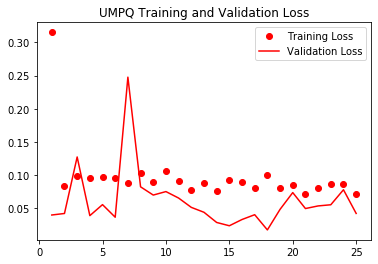

In [102]:
umpq_loss = umpq_history.history['loss']
umpq_val_loss = umpq_history.history['val_loss']
epochs = range(1, len(umpq_loss)+1)

plt.figure()
plt.plot(epochs, umpq_loss, 'ro', label='Training Loss')
plt.plot(epochs, umpq_val_loss, 'r', label='Validation Loss')
plt.title('UMPQ Training and Validation Loss')
plt.legend()
plt.show()

In [103]:
umpq_model = Sequential()
umpq_model.add(layers.GRU(32, dropout=0.2,
                          recurrent_dropout=0.2,
                          input_shape=(None, umpq.shape[-1])))
umpq_model.add(layers.Dense(1))
umpq_model.compile(optimizer=RMSprop(), loss='mae')
umpq_history = umpq_model.fit_generator(umpq_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=umpq_val_gen, 
                              validation_steps=umpq_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 79ms/step - loss: 0.4330 - val_loss: 0.0730
Epoch 2/25
10/10 [==============================] - 0s 21ms/step - loss: 0.3330 - val_loss: 0.1400
Epoch 3/25
10/10 [==============================] - 0s 20ms/step - loss: 0.2818 - val_loss: 0.0914
Epoch 4/25
10/10 [==============================] - 0s 19ms/step - loss: 0.3090 - val_loss: 0.0773
Epoch 5/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2583 - val_loss: 0.1081
Epoch 6/25
10/10 [==============================] - 0s 18ms/step - loss: 0.2820 - val_loss: 0.0539
Epoch 7/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2424 - val_loss: 0.0535
Epoch 8/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2241 - val_loss: 0.0370
Epoch 9/25
10/10 [==============================] - 0s 19ms/step - loss: 0.2795 - val_loss: 0.0773
Epoch 10/25
10/10 [==============================] - 0s 18ms/step - loss: 0.1982 - val_loss: 0.1049
Epoch 11/

In [104]:
#the high on the day after this was 11.56
x = umpq_model.predict(umpq_current)
y = (x*umpq_std[1])+umpq_mean[1]
print(y)

[[16.884]]


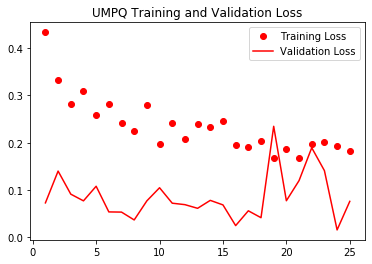

In [105]:
umpq_loss = umpq_history.history['loss']
umpq_val_loss = umpq_history.history['val_loss']
epochs = range(1, len(umpq_loss)+1)

plt.figure()
plt.plot(epochs, umpq_loss, 'ro', label='Training Loss')
plt.plot(epochs, umpq_val_loss, 'r', label='Validation Loss')
plt.title('UMPQ Training and Validation Loss')
plt.legend()
plt.show()

In [106]:
umpq_model = Sequential()
umpq_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, umpq.shape[-1])))
umpq_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
umpq_model.add(layers.Dense(1))
umpq_model.compile(optimizer=RMSprop(), loss='mae')
umpq_history = umpq_model.fit_generator(umpq_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=umpq_val_gen, 
                              validation_steps=umpq_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 144ms/step - loss: 2.1725 - val_loss: 0.1494
Epoch 2/25
10/10 [==============================] - 0s 29ms/step - loss: 2.0409 - val_loss: 0.1920
Epoch 3/25
10/10 [==============================] - 0s 29ms/step - loss: 1.2325 - val_loss: 0.1765
Epoch 4/25
10/10 [==============================] - 0s 30ms/step - loss: 1.2990 - val_loss: 0.2870
Epoch 5/25
10/10 [==============================] - 0s 30ms/step - loss: 1.2199 - val_loss: 0.2829
Epoch 6/25
10/10 [==============================] - 0s 29ms/step - loss: 0.8335 - val_loss: 0.4050
Epoch 7/25
10/10 [==============================] - 0s 30ms/step - loss: 0.8790 - val_loss: 0.4568
Epoch 8/25
10/10 [==============================] - 0s 30ms/step - loss: 0.8158 - val_loss: 0.2485
Epoch 9/25
10/10 [==============================] - 0s 29ms/step - loss: 0.8361 - val_loss: 0.1423
Epoch 10/25
10/10 [==============================] - 0s 30ms/step - loss: 0.7302 - val_loss: 0.0724
Epoch 11

In [107]:
#the high on the day after this was 11.56
x = umpq_model.predict(umpq_current)
y = (x*umpq_std[1])+umpq_mean[1]
print(y)

[[14.703314]]


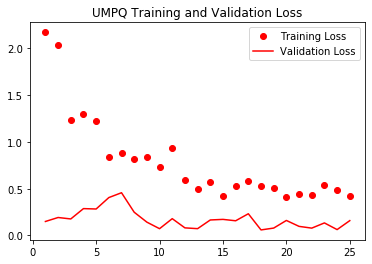

In [108]:
umpq_loss = umpq_history.history['loss']
umpq_val_loss = umpq_history.history['val_loss']
epochs = range(1, len(umpq_loss)+1)

plt.figure()
plt.plot(epochs, umpq_loss, 'ro', label='Training Loss')
plt.plot(epochs, umpq_val_loss, 'r', label='Validation Loss')
plt.title('UMPQ Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for BMTC**

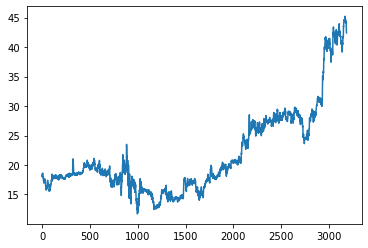

In [109]:
bmtc = bmtc_df.to_numpy()
bmtc_high = bmtc[:,1]

plt.plot(range(len(bmtc_high)), bmtc_high)

In [110]:
bmtc_mean = bmtc.mean(axis=0)
bmtc -= bmtc_mean
bmtc_std = bmtc.std(axis=0)
bmtc /= bmtc_std

In [111]:
bmtc_current = np.array([[26.00,26.40,25.75,26.23,93186],
               [26.69,27.31,25.87,26.17,61843],
               [26.27,26.88,25.82,26.51,46000],
               [27.09,29.59,27.05,28.82,104362],
               [29.86,29.95,28.92,29.32,62443],
               [30.48,31.43,28.32,30.55,99504],
               [29.34,29.95,28.73,29.12,77651],
               [28.17,28.49,27.38,27.98,65330],
               [27.65,27.98,27.34,27.65,35308],
               [28.29,28.41,26.69,26.74,61929]])


bmtc_current = np.reshape(bmtc_current, (1,10,5))

In [112]:
bmtc_train_gen = generator(bmtc, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
bmtc_val_gen = generator(bmtc, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
bmtc_test_gen = generator(bmtc, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

bmtc_val_steps = (3000 - 2501) // bs
bmtc_test_steps = (len(bmtc) - 3001 - lookback) // bs

In [113]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(bmtc_val_steps):
        samples, targets = next(bmtc_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.048815427471348614


In [114]:
bmtc_model = Sequential()
bmtc_model.add(layers.Flatten(input_shape=(lookback // step, bmtc.shape[-1])))
bmtc_model.add(layers.Dense(32, activation='relu'))
bmtc_model.add(layers.Dense(1))
bmtc_model.compile(optimizer=RMSprop(), loss='mae')
bmtc_history = bmtc_model.fit_generator(bmtc_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=bmtc_val_gen, 
                              validation_steps=bmtc_val_steps)

Epoch 1/25
10/10 [==============================] - 0s 17ms/step - loss: 0.2409 - val_loss: 0.6161
Epoch 2/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1733 - val_loss: 0.3704
Epoch 3/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1510 - val_loss: 0.3403
Epoch 4/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1717 - val_loss: 0.3139
Epoch 5/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1367 - val_loss: 0.1810
Epoch 6/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1504 - val_loss: 0.4808
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1223 - val_loss: 0.4418
Epoch 8/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1341 - val_loss: 0.1904
Epoch 9/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1052 - val_loss: 0.2804
Epoch 10/25
10/10 [==============================] - 0s 9ms/step - loss: 0.1141 - val_loss: 0.4708
Epoch 11/25
10/10 

In [115]:
#the high on the day after this was 26.85
x = bmtc_model.predict(bmtc_current)
y = (x*bmtc_std[1])+bmtc_mean[1]
print(y)

[[30773.893]]


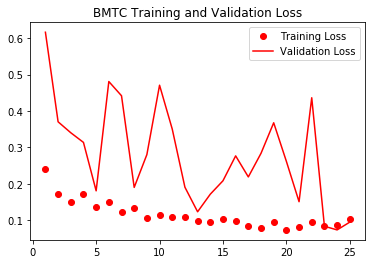

In [116]:
bmtc_loss = bmtc_history.history['loss']
bmtc_val_loss = bmtc_history.history['val_loss']
epochs = range(1, len(bmtc_loss)+1)

plt.figure()
plt.plot(epochs, bmtc_loss, 'ro', label='Training Loss')
plt.plot(epochs, bmtc_val_loss, 'r', label='Validation Loss')
plt.title('BMTC Training and Validation Loss')
plt.legend()
plt.show()

In [117]:
bmtc_model = Sequential()
bmtc_model.add(layers.GRU(32, input_shape=(None, bmtc.shape[-1])))
bmtc_model.add(layers.Dense(1))
bmtc_model.compile(optimizer=RMSprop(), loss='mae')
bmtc_history = bmtc_model.fit_generator(bmtc_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=bmtc_val_gen, 
                              validation_steps=bmtc_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 66ms/step - loss: 0.1862 - val_loss: 0.2391
Epoch 2/25
10/10 [==============================] - 0s 18ms/step - loss: 0.0642 - val_loss: 0.0657
Epoch 3/25
10/10 [==============================] - 0s 17ms/step - loss: 0.0564 - val_loss: 0.1377
Epoch 4/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0513 - val_loss: 0.1378
Epoch 5/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0555 - val_loss: 0.0912
Epoch 6/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0543 - val_loss: 0.4460
Epoch 7/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0523 - val_loss: 0.4702
Epoch 8/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0531 - val_loss: 0.7798
Epoch 9/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0588 - val_loss: 0.9272
Epoch 10/25
10/10 [==============================] - 0s 16ms/step - loss: 0.0593 - val_loss: 0.7302
Epoch 11/

In [118]:
#the high on the day after this was 26.85
x = bmtc_model.predict(bmtc_current)
y = (x*bmtc_std[1])+bmtc_mean[1]
print(y)

[[24.391266]]


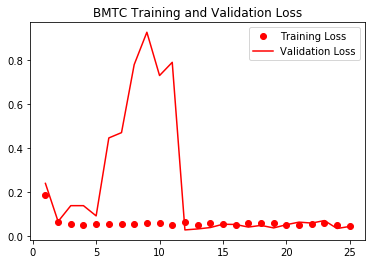

In [119]:
bmtc_loss = bmtc_history.history['loss']
bmtc_val_loss = bmtc_history.history['val_loss']
epochs = range(1, len(bmtc_loss)+1)

plt.figure()
plt.plot(epochs, bmtc_loss, 'ro', label='Training Loss')
plt.plot(epochs, bmtc_val_loss, 'r', label='Validation Loss')
plt.title('BMTC Training and Validation Loss')
plt.legend()
plt.show()

In [120]:
bmtc_model = Sequential()
bmtc_model.add(layers.GRU(32, dropout=0.2,
                          recurrent_dropout=0.2,
                          input_shape=(None, bmtc.shape[-1])))
bmtc_model.add(layers.Dense(1))
bmtc_model.compile(optimizer=RMSprop(), loss='mae')
bmtc_history = bmtc_model.fit_generator(bmtc_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=bmtc_val_gen, 
                              validation_steps=bmtc_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 76ms/step - loss: 0.2163 - val_loss: 0.2494
Epoch 2/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1873 - val_loss: 0.1446
Epoch 3/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1772 - val_loss: 0.1801
Epoch 4/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1834 - val_loss: 0.2461
Epoch 5/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1649 - val_loss: 0.2389
Epoch 6/25
10/10 [==============================] - 0s 18ms/step - loss: 0.1640 - val_loss: 0.2254
Epoch 7/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1604 - val_loss: 0.1998
Epoch 8/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1365 - val_loss: 0.2232
Epoch 9/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1468 - val_loss: 0.2636
Epoch 10/25
10/10 [==============================] - 0s 19ms/step - loss: 0.1373 - val_loss: 0.1943
Epoch 11/

In [121]:
#the high on the day after this was 26.85
x = bmtc_model.predict(bmtc_current)
y = (x*bmtc_std[1])+bmtc_mean[1]
print(y)

[[18.742664]]


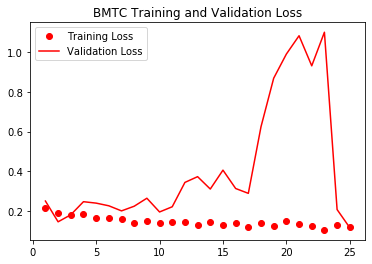

In [122]:
bmtc_loss = bmtc_history.history['loss']
bmtc_val_loss = bmtc_history.history['val_loss']
epochs = range(1, len(bmtc_loss)+1)

plt.figure()
plt.plot(epochs, bmtc_loss, 'ro', label='Training Loss')
plt.plot(epochs, bmtc_val_loss, 'r', label='Validation Loss')
plt.title('BMTC Training and Validation Loss')
plt.legend()
plt.show()

In [123]:
bmtc_model = Sequential()
bmtc_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, bmtc.shape[-1])))
bmtc_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
bmtc_model.add(layers.Dense(1))
bmtc_model.compile(optimizer=RMSprop(), loss='mae')
bmtc_history = bmtc_model.fit_generator(bmtc_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=bmtc_val_gen, 
                              validation_steps=bmtc_val_steps)

Epoch 1/25
10/10 [==============================] - 1s 147ms/step - loss: 0.9697 - val_loss: 0.9168
Epoch 2/25
10/10 [==============================] - 0s 30ms/step - loss: 0.5515 - val_loss: 0.9048
Epoch 3/25
10/10 [==============================] - 0s 29ms/step - loss: 0.5762 - val_loss: 0.8239
Epoch 4/25
10/10 [==============================] - 0s 30ms/step - loss: 0.4799 - val_loss: 0.8540
Epoch 5/25
10/10 [==============================] - 0s 30ms/step - loss: 0.3254 - val_loss: 0.7802
Epoch 6/25
10/10 [==============================] - 0s 29ms/step - loss: 0.3481 - val_loss: 0.7288
Epoch 7/25
10/10 [==============================] - 0s 29ms/step - loss: 0.2792 - val_loss: 0.7145
Epoch 8/25
10/10 [==============================] - 0s 29ms/step - loss: 0.2712 - val_loss: 0.7057
Epoch 9/25
10/10 [==============================] - 0s 30ms/step - loss: 0.3102 - val_loss: 0.5585
Epoch 10/25
10/10 [==============================] - 0s 30ms/step - loss: 0.2432 - val_loss: 0.4102
Epoch 11

In [124]:
#the high on the day after this was 26.85
x = bmtc_model.predict(bmtc_current)
y = (x*bmtc_std[1])+bmtc_mean[1]
print(y)

[[19.510075]]


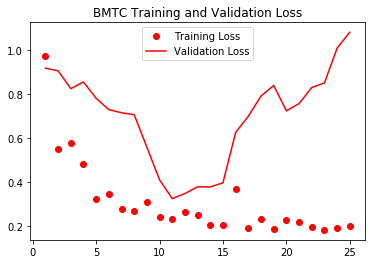

In [125]:
bmtc_loss = bmtc_history.history['loss']
bmtc_val_loss = bmtc_history.history['val_loss']
epochs = range(1, len(bmtc_loss)+1)

plt.figure()
plt.plot(epochs, bmtc_loss, 'ro', label='Training Loss')
plt.plot(epochs, bmtc_val_loss, 'r', label='Validation Loss')
plt.title('BMTC Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for PNI**

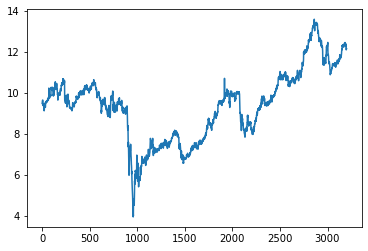

In [126]:
pni = pni_df.to_numpy()
pni_high = pni[:,1]

plt.plot(range(len(pni_high)), pni_high)

In [127]:
pni_mean = pni.mean(axis=0)
pni -= pni_mean
pni_std = pni.std(axis=0)
pni /= pni_std

In [132]:
pni_current = np.array([[9.57,9.64,9.48,9.52,76382],
               [9.63,9.63,9.49,9.52,39008],
               [9.53,9.55,9.36,9.50,36604],
               [9.49,9.51,9.23,9.30,89392],
               [9.36,9.52,9.36,9.45,72724],
               [9.75,9.82,9.40,9.49,114583],
               [9.49,9.54,9.17,9.38,67798],
               [9.41,9.69,9.49,9.67,48137],
               [9.64,9.71,9.62,9.64,30089],
               [9.89,9.94,9.73,9.93,55904]])


pni_current = np.reshape(pni_current, (1,10,5))

SyntaxError: invalid syntax (<ipython-input-132-de72bbf3a857>, line 10)

In [129]:
pni_train_gen = generator(pni, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
pni_val_gen = generator(pni, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
pni_test_gen = generator(pni, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

pni_val_steps = (3000 - 2501) // bs
pni_test_steps = (len(pni) - 3001 - lookback) // bs

In [130]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(pni_val_steps):
        samples, targets = next(pni_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.0460579744959739


In [ ]:
pni_model = Sequential()
pni_model.add(layers.Flatten(input_shape=(lookback // step, pni.shape[-1])))
pni_model.add(layers.Dense(32, activation='relu'))
pni_model.add(layers.Dense(1))
pni_model.compile(optimizer=RMSprop(), loss='mae')
pni_history = pni_model.fit_generator(pni_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=pni_val_gen, 
                              validation_steps=pni_val_steps)

In [ ]:
#the high on the day after this was 9.97
x = pni_model.predict(pni_current)
y = (x*pni_std[1])+pni_mean[1]
print(y)

In [ ]:
pni_loss = pni_history.history['loss']
pni_val_loss = pni_history.history['val_loss']
epochs = range(1, len(pni_loss)+1)

plt.figure()
plt.plot(epochs, pni_loss, 'ro', label='Training Loss')
plt.plot(epochs, pni_val_loss, 'r', label='Validation Loss')
plt.title('PNI Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
pni_model = Sequential()
pni_model.add(layers.GRU(32, input_shape=(None, pni.shape[-1])))
pni_model.add(layers.Dense(1))
pni_model.compile(optimizer=RMSprop(), loss='mae')
pni_history = pni_model.fit_generator(pni_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=pni_val_gen, 
                              validation_steps=pni_val_steps)

In [ ]:
#the high on the day after this was 9.97
x = pni_model.predict(pni_current)
y = (x*pni_std[1])+pni_mean[1]
print(y)

In [ ]:
pni_loss = pni_history.history['loss']
pni_val_loss = pni_history.history['val_loss']
epochs = range(1, len(pni_loss)+1)

plt.figure()
plt.plot(epochs, pni_loss, 'ro', label='Training Loss')
plt.plot(epochs, pni_val_loss, 'r', label='Validation Loss')
plt.title('PNI Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
pni_model = Sequential()
pni_model.add(layers.GRU(32, dropout=0.2,
                         recurrent_dropout=0.2,
                         input_shape=(None, pni.shape[-1])))
pni_model.add(layers.Dense(1))
pni_model.compile(optimizer=RMSprop(), loss='mae')
pni_history = pni_model.fit_generator(pni_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=pni_val_gen, 
                              validation_steps=pni_val_steps)

In [ ]:
#the high on the day after this was 9.97
x = pni_model.predict(pni_current)
y = (x*pni_std[1])+pni_mean[1]
print(y)

In [ ]:
pni_loss = pni_history.history['loss']
pni_val_loss = pni_history.history['val_loss']
epochs = range(1, len(pni_loss)+1)

plt.figure()
plt.plot(epochs, pni_loss, 'ro', label='Training Loss')
plt.plot(epochs, pni_val_loss, 'r', label='Validation Loss')
plt.title('PNI Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
pni_model = Sequential()
pni_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, pni.shape[-1])))
pni_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
pni_model.add(layers.Dense(1))
pni_model.compile(optimizer=RMSprop(), loss='mae')
pni_history = pni_model.fit_generator(pni_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=pni_val_gen, 
                              validation_steps=pni_val_steps)

In [ ]:
#the high on the day after this was 9.97
x = pni_model.predict(pni_current)
y = (x*pni_std[1])+pni_mean[1]
print(y)

In [ ]:
pni_loss = pni_history.history['loss']
pni_val_loss = pni_history.history['val_loss']
epochs = range(1, len(pni_loss)+1)

plt.figure()
plt.plot(epochs, pni_loss, 'ro', label='Training Loss')
plt.plot(epochs, pni_val_loss, 'r', label='Validation Loss')
plt.title('PNI Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for ITCB**

In [ ]:
itcb = itcb_df.to_numpy()
itcb_high = itcb[:,1]

plt.plot(range(len(itcb_high)), itcb_high)

In [ ]:
itcb_mean = itcb.mean(axis=0)
itcb -= itcb_mean
itcb_std = itcb.std(axis=0)
itcb /= itcb_std

In [ ]:
itcb_current = np.array([[3.86,4.23,3.86,3.94,18230],
               [3.87,4.06,3.70,3.77,7495],
               [3.69,3.97,3.67,3.97,5593],
               [4.16,4.16,3.77,3.93,4229],
               [4.11,4.25,3.88,4.20,4135],
               [4.54,4.54,4.04,4.21,8607],
               [4.27,4.27,4.27,4.27,404],
               [3.79,4.00,3.79,3.93,1704],
               [3.80,4.25,3.80,4.25,4724],
               [3.76,4.32,3.76,4.13,11240]])


itcb_current = np.reshape(itcb_current, (1,10,5))

In [ ]:
itcb_train_gen = generator(itcb, lookback=lookback, delay=delay, min_index=0, max_index=2500, shuffle=True, batch_size=bs, step=step)
itcb_val_gen = generator(itcb, lookback=lookback, delay=delay, min_index=2501, max_index=3000, batch_size=bs, step=step)
itcb_test_gen = generator(itcb, lookback=lookback, delay=delay, min_index=3001, max_index=None, batch_size=bs, step=step)

itcb_val_steps = (3000 - 2501) // bs
itcb_test_steps = (len(itcb) - 3001 - lookback) // bs

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(itcb_val_steps):
        samples, targets = next(itcb_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

In [ ]:
itcb_model = Sequential()
itcb_model.add(layers.Flatten(input_shape=(lookback // step, itcb.shape[-1])))
itcb_model.add(layers.Dense(32, activation='relu'))
itcb_model.add(layers.Dense(1))
itcb_model.compile(optimizer=RMSprop(), loss='mae')
itcb_history = itcb_model.fit_generator(itcb_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=itcb_val_gen, 
                              validation_steps=itcb_val_steps)

In [ ]:
#the high on the day after this was 4.30
x = itcb_model.predict(itcb_current)
y = (x*itcb_std[1])+itcb_mean[1]
print(y)

In [ ]:
itcb_loss = itcb_history.history['loss']
itcb_val_loss = itcb_history.history['val_loss']
epochs = range(1, len(itcb_loss)+1)

plt.figure()
plt.plot(epochs, itcb_loss, 'ro', label='Training Loss')
plt.plot(epochs, itcb_val_loss, 'r', label='Validation Loss')
plt.title('ITCB Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
itcb_model = Sequential()
itcb_model.add(layers.GRU(32, input_shape=(None, itcb.shape[-1])))
itcb_model.add(layers.Dense(1))
itcb_model.compile(optimizer=RMSprop(), loss='mae')
itcb_history = itcb_model.fit_generator(itcb_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=itcb_val_gen, 
                              validation_steps=itcb_val_steps)

In [ ]:
#the high on the day after this was 4.30
x = itcb_model.predict(itcb_current)
y = (x*itcb_std[1])+itcb_mean[1]
print(y)

In [ ]:
itcb_loss = itcb_history.history['loss']
itcb_val_loss = itcb_history.history['val_loss']
epochs = range(1, len(itcb_loss)+1)

plt.figure()
plt.plot(epochs, itcb_loss, 'ro', label='Training Loss')
plt.plot(epochs, itcb_val_loss, 'r', label='Validation Loss')
plt.title('ITCB Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
itcb_model = Sequential()
itcb_model.add(layers.GRU(32, dropout=0.2,
                          recurrent_dropout=0.2,
                          input_shape=(None, itcb.shape[-1])))
itcb_model.add(layers.Dense(1))
itcb_model.compile(optimizer=RMSprop(), loss='mae')
itcb_history = itcb_model.fit_generator(itcb_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=itcb_val_gen, 
                              validation_steps=itcb_val_steps)

In [ ]:
#the high on the day after this was 4.30
x = itcb_model.predict(itcb_current)
y = (x*itcb_std[1])+itcb_mean[1]
print(y)

In [ ]:
itcb_loss = itcb_history.history['loss']
itcb_val_loss = itcb_history.history['val_loss']
epochs = range(1, len(itcb_loss)+1)

plt.figure()
plt.plot(epochs, itcb_loss, 'ro', label='Training Loss')
plt.plot(epochs, itcb_val_loss, 'r', label='Validation Loss')
plt.title('ITCB Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
itcb_model = Sequential()
itcb_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, itcb.shape[-1])))
itcb_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
itcb_model.add(layers.Dense(1))
itcb_model.compile(optimizer=RMSprop(), loss='mae')
itcb_history = itcb_model.fit_generator(itcb_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=itcb_val_gen, 
                              validation_steps=itcb_val_steps)

In [ ]:
#the high on the day after this was 4.30
x = itcb_model.predict(itcb_current)
y = (x*itcb_std[1])+itcb_mean[1]
print(y)

In [ ]:
itcb_loss = itcb_history.history['loss']
itcb_val_loss = itcb_history.history['val_loss']
epochs = range(1, len(itcb_loss)+1)

plt.figure()
plt.plot(epochs, itcb_loss, 'ro', label='Training Loss')
plt.plot(epochs, itcb_val_loss, 'r', label='Validation Loss')
plt.title('ITCB Training and Validation Loss')
plt.legend()
plt.show()

# **This is the example for IBM**

In [ ]:
ibm = ibm_df.to_numpy()
ibm_high = ibm[:,1]

plt.plot(range(len(ibm_high)), ibm_high)

In [ ]:
ibm_mean = ibm.mean(axis=0)
ibm -= ibm_mean
ibm_std = ibm.std(axis=0)
ibm /= ibm_std

In [ ]:
ibm_current = np.array([[119.87,120.33,117.55,119.31,7090000],
               [119.57,123.03,119.12,121.35,6880000],
               [122.41,125.00,120.76,124.72,4990000],
               [125.56,126.99,125.47,125.92,4920000],
               [128.03,128.20,125.38,126.27,4780000],
               [128.88,129.31,127.53,128.69,5260000],
               [126.52,127.27,125.22,125.56,6640000],
               [123.19,123.47,121.39,121.87,4930000],
               [120.82,121.97,119.39,121.68,4020000],
               [123.39,124.32,122.47,122.58,3900000]])

ibm_current = np.reshape(ibm_current, (1,10,5))

In [ ]:
ibm_train_gen = generator(ibm, lookback=lookback, delay=delay, min_index=0, max_index=10000, shuffle=True, batch_size=bs, step=step)
ibm_val_gen = generator(ibm, lookback=lookback, delay=delay, min_index=10001, max_index=12000, batch_size=bs, step=step)
ibm_test_gen = generator(ibm, lookback=lookback, delay=delay, min_index=12001, max_index=None, batch_size=bs, step=step)

ibm_val_steps = (12000 - 10001) // bs
ibm_test_steps = (len(ibm) - 12001 - lookback) // bs

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(ibm_val_steps):
        samples, targets = next(ibm_val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

In [ ]:
ibm_model = Sequential()
ibm_model.add(layers.Flatten(input_shape=(lookback // step, ibm.shape[-1])))
ibm_model.add(layers.Dense(32, activation='relu'))
ibm_model.add(layers.Dense(1))
ibm_model.compile(optimizer=RMSprop(), loss='mae')
ibm_history = ibm_model.fit_generator(ibm_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ibm_val_gen, 
                              validation_steps=ibm_val_steps)

In [ ]:
#the high the day after this was 124.05
x = ibm_model.predict(ibm_current)
y = (x*ibm_std[1])+ibm_mean[1]
print(y)

In [ ]:
ibm_loss = ibm_history.history['loss']
ibm_val_loss = ibm_history.history['val_loss']
epochs = range(1, len(ibm_loss)+1)

plt.figure()
plt.plot(epochs, ibm_loss, 'ro', label='Training Loss')
plt.plot(epochs, ibm_val_loss, 'r', label='Validation Loss')
plt.title('IBM Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
ibm_model = Sequential()
ibm_model.add(layers.GRU(32, input_shape=(None, ibm.shape[-1])))
ibm_model.add(layers.Dense(1))
ibm_model.compile(optimizer=RMSprop(), loss='mae')
ibm_history = ibm_model.fit_generator(ibm_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ibm_val_gen, 
                              validation_steps=ibm_val_steps)

In [ ]:
#the high the day after this was 124.05
x = ibm_model.predict(ibm_current)
y = (x*ibm_std[1])+ibm_mean[1]
print(y)

In [ ]:
ibm_loss = ibm_history.history['loss']
ibm_val_loss = ibm_history.history['val_loss']
epochs = range(1, len(ibm_loss)+1)

plt.figure()
plt.plot(epochs, ibm_loss, 'ro', label='Training Loss')
plt.plot(epochs, ibm_val_loss, 'r', label='Validation Loss')
plt.title('IBM Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
ibm_model = Sequential()
ibm_model.add(layers.GRU(32, dropout=0.2,
                         recurrent_dropout=0.2,
                         input_shape=(None, ibm.shape[-1])))
ibm_model.add(layers.Dense(1))
ibm_model.compile(optimizer=RMSprop(), loss='mae')
ibm_history = ibm_model.fit_generator(ibm_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ibm_val_gen, 
                              validation_steps=ibm_val_steps)

In [ ]:
#the high the day after this was 124.05
x = ibm_model.predict(ibm_current)
y = (x*ibm_std[1])+ibm_mean[1]
print(y)

In [ ]:
ibm_loss = ibm_history.history['loss']
ibm_val_loss = ibm_history.history['val_loss']
epochs = range(1, len(ibm_loss)+1)

plt.figure()
plt.plot(epochs, ibm_loss, 'ro', label='Training Loss')
plt.plot(epochs, ibm_val_loss, 'r', label='Validation Loss')
plt.title('IBM Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
ibm_model = Sequential()
ibm_model.add(layers.GRU(32, dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(None, ibm.shape[-1])))
ibm_model.add(layers.GRU(64, activation='relu',
                        dropout=0.1,
                        recurrent_dropout=0.5))
ibm_model.add(layers.Dense(1))
ibm_model.compile(optimizer=RMSprop(), loss='mae')
ibm_history = ibm_model.fit_generator(ibm_train_gen, 
                              steps_per_epoch=10, 
                              epochs=25, 
                              validation_data=ibm_val_gen, 
                              validation_steps=ibm_val_steps)

In [ ]:
#the high the day after this was 124.05
x = ibm_model.predict(ibm_current)
y = (x*ibm_std[1])+ibm_mean[1]
print(y)

In [ ]:
ibm_loss = ibm_history.history['loss']
ibm_val_loss = ibm_history.history['val_loss']
epochs = range(1, len(ibm_loss)+1)

plt.figure()
plt.plot(epochs, ibm_loss, 'ro', label='Training Loss')
plt.plot(epochs, ibm_val_loss, 'r', label='Validation Loss')
plt.title('IBM Training and Validation Loss')
plt.legend()
plt.show()